# Code Generation

In [1]:
from sympy import *
x, y, z = symbols('x y z')
init_printing()

In [2]:
%matplotlib inline

Code generation refers to converting a SymPy expression into code from another language so that it can be numerically evaluated. SymPy supports most popular languages, including

- Python (NumPy/SciPy)
- C
- C++
- Fortran
- MATLAB/Octave
- Julia
- Mathematica
- Javascript
- LLVM
- Rust
- Theano
- Tensorflow
- PyTorch
- And more...
- Easy to extend to others...

The basic idea for using SymPy to model a real world problem is to split this into three steps: first use SymPy to model the problem mathematically, then use SymPy's codegen tools to convert this symbolic model into something that can be numerically evaluated, and finally, use these numerical libraries and/or languages to evaluate the problem on data.

![codegen](images/codegen1.png)

This section of the tutorial focuses on the second step here.

## Code Printers

The most basic form of code generation are the code printers. The convert SymPy expressions into the target language. 

The most common languages are C, C++, Fortran, and Python, but over a dozen languages are supported. Here, we will quickly go over each supported language. 

Let us use the function $$|\sin(x^2)|.$$

In [3]:
expr = abs(sin(x**2))
expr

In [4]:
ccode(expr) # C

'fabs(sin(pow(x, 2)))'

In [5]:
fcode(expr) # Fortran

'      abs(sin(x**2))'

In [6]:
julia_code(expr) # Julia

'abs(sin(x .^ 2))'

In [7]:
jscode(expr) # Javascript

'Math.abs(Math.sin(Math.pow(x, 2)))'

In [8]:
mathematica_code(expr) # Mathematica

'Abs[Sin[x^2]]'

In [9]:
octave_code(expr) # Octave/MATLAB

'abs(sin(x.^2))'

In [10]:
rust_code(expr) # Rust

'(x.powi(2)).sin().abs()'

In [11]:
rcode(expr) # R

'abs(sin(x^2))'

In [12]:
cxxcode(expr) # C++

'std::fabs(std::sin(std::pow(x, 2)))'

### Exercise: Codegen your own function

Come up with a symbolic expression and try generating code for it in each language. Note, some languages don't support everything. What works and what doesn't? What things are the same across languages and what things are different?

**Reminder: If you click a cell and press `b` it will add a new cell below it.**

In [13]:
# Write your answer here


## Lambdify

In addition to generating a string for code, SymPy also supports directly executing that code. The most basic and useful instances of this is the `lambdify` function. `lambdify(x, expr)` takes an expression and converts it into an equivalent function that can be evaluated using NumPy.

In [14]:
expr = abs(sin(x**2))
expr

In [15]:
f = lambdify(x, expr)

`f` is now a function that can be evaluated on numerical inputs.

In [16]:
f(1.0)

In [17]:
import numpy as np
a = np.linspace(0, 10)

In [18]:
f(a)

array([0.        , 0.04163727, 0.16582768, 0.36612719, 0.61815157,
       0.86302765, 0.9974506 , 0.89155923, 0.45826007, 0.22992604,
       0.85385059, 0.94695307, 0.28181405, 0.68568806, 0.95255185,
       0.0536568 , 0.94495142, 0.50529106, 0.8004267 , 0.62299159,
       0.81443908, 0.4637374 , 0.9658519 , 0.04132612, 0.90977307,
       0.78213152, 0.11911495, 0.86919774, 0.94484948, 0.45248759,
       0.21308396, 0.72821575, 0.97195378, 0.98065977, 0.85352622,
       0.68523456, 0.5399976 , 0.45220985, 0.43617826, 0.49405856,
       0.61741691, 0.78174326, 0.93658562, 0.99917758, 0.86659578,
       0.46456494, 0.1645991 , 0.78154902, 0.99001393, 0.50636564])

Note that this is much faster than trying to evaluate the function numerically with SymPy

In [19]:
%%timeit
[expr.subs(x, i) for i in a]

2.46 ms ± 525 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [20]:
%%timeit
f(a)

1.67 µs ± 16.9 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


Using SymPy to evaluate expressions numerically is OK for a few points, or if you want to make use of SymPy's more accurate arbitrary floating-point numbers, but if you are doing a lot of numeric computation, you are better off using `lambdify` and evaluating with NumPy (or code generation and a different library/language).

### How Lambdify Works
The way to think of `lambdify` is that it's as if took our SymPy expression, `abs(sin(x**2))` and we wrote "`f = lambda x: np.abs(np.sin(x**2))`.

Under the hood, this is roughly what it is doing. We can use `??` to view the source code for `f`:

In [21]:
f??

Signature: f(x)
Docstring:
Created with lambdify. Signature:

func(x)

Expression:

Abs(sin(x**2))

Source code:

def _lambdifygenerated(x):
    return abs(sin(x**2))


Imported modules:
Source:   
def _lambdifygenerated(x):
    return abs(sin(x**2))
File:      ~/Documents/scipy-2023-tutorial/tutorials/<lambdifygenerated-1>
Type:      function

The source is literally just `return abs(sin(x**2))`. Except in this function's namespace, `abs` and `sin` come from `numpy` (imagine there is a `from numpy import *` at the top). `lambdify` also automatically handles translation of SymPy idioms into NumPy ones, for example:

In [22]:
g = lambdify(x, acos(x))
g??

Signature: g(x)
Docstring:
Created with lambdify. Signature:

func(x)

Expression:

acos(x)

Source code:

def _lambdifygenerated(x):
    return arccos(x)


Imported modules:
Source:   
def _lambdifygenerated(x):
    return arccos(x)
File:      ~/Documents/scipy-2023-tutorial/tutorials/<lambdifygenerated-2>
Type:      function

SymPy calls $\cos^{-1}(x)$ `acos(x)` but NumPy calls it `arccos(x)`. `lambdify` automatically translates one to the other. 

### Example: Using lambdify to numerically solve equations

You can also use `lambdify` to convert an expression into a function which can be passed to a numerical solver like `fsolve`. Let's look at solving $\cos(x) = x$ from the [solvers notebook](05-Solvers.ipynb).

In [23]:
from scipy.optimize import fsolve

Let's look at the help for `fsolve`:

In [24]:
fsolve?

Signature:
fsolve(
    func,
    x0,
    args=(),
    fprime=None,
    full_output=0,
    col_deriv=0,
    xtol=1.49012e-08,
    maxfev=0,
    band=None,
    epsfcn=None,
    factor=100,
    diag=None,
)
Docstring:
Find the roots of a function.

Return the roots of the (non-linear) equations defined by
``func(x) = 0`` given a starting estimate.

Parameters
----------
func : callable ``f(x, *args)``
    A function that takes at least one (possibly vector) argument,
    and returns a value of the same length.
x0 : ndarray
    The starting estimate for the roots of ``func(x) = 0``.
args : tuple, optional
    Any extra arguments to `func`.
fprime : callable ``f(x, *args)``, optional
    A function to compute the Jacobian of `func` with derivatives
    across the rows. By default, the Jacobian will be estimated.
full_output : bool, optional
    If True, return optional outputs.
col_deriv : bool, optional
    Specify whether the Jacobian function computes derivatives down
    the columns (fa

We can see that, like `nsolve`, `fsolve` takes a function and a starting point. The function should be an expression that equals 0 (another reason to prefer that instead of `Eq`). We can create the function with lambdify

In [25]:
f = lambdify(x, cos(x) - x)

In [26]:
fsolve(f, 1)

array([0.73908513])

### Exercise

Solve these equations numerically, using `lambdify` and `fsolve`.

$$x^2 + 2x - 4 = 0$$
$$\tan(x) = \sin(x)$$

Remember that these equations have multiple solutions, so you may need to use multiple different starting points to find them all.

### Solving Systems of Equations with Lambdify and fsolve

Let's look at how to solve the system of equations from the [solvers notebook](05-Solvers.ipynb) numerically with `lambdify` and `fsolve`.

In [27]:
equations = [cos(x) - sin(y), cos(x)*y - 1]

To solve a system with `fsolve`, we need a to create a function `f(a)` that returns an array of the values of the two functions at a given `a` point, where `a` is an array of two values. 

To do this, we can use `IndexedBase`. `IndexedBase` creates a special kind of symbol that can be indexed. It is very useful for code generation as it can be used to represent an array. For example,

In [28]:
a = IndexedBase('a')
a[0]

IndexedBase also supports symbolic indices.

In [29]:
i = Symbol('i')
a[i]

When used in `lambdify`, IndexedBase can be used to index the variable. For example, to create a lambdified function that always returns the first element of the input array, we can use

In [30]:
f = lambdify(a, a[0])
f(np.array([10, 20, 30]))

10

So to solve our system of equations with `fsolve`, let's create an `IndexedBase` so that the two variables `x` and `y` can be replaced with a single array variable, `a[0]`, and `a[1]`.

In [31]:
a = IndexedBase('a')
equations_a = [expr.subs({x: a[0], y: a[1]}) for expr in equations]
equations_a

In [32]:
f = lambdify(a, equations_a)

Let's verify that `f` accepts a single array argument, like `fsolve` requires.

In [33]:
import numpy as np
arr = np.array([0, 1])

In [34]:
f(arr)

In [35]:
fsolve(f, [1, 1])

array([0.45663919, 1.11415714])

## Exercise

SymPy has a `plot` function which plots a symbolic expression. For example:

In [36]:
expr = abs(sin(x**2))

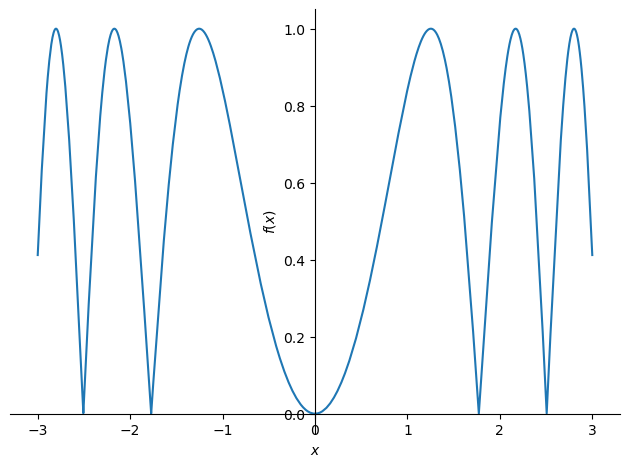

In [37]:
plot(expr, (x, -3, 3));

We can easily build our own plotting function using lambdify. Write your own `plot` function that takes an input expression, lambdifies it, then plots it with `matplotlib.pyplot.plot`. Remember that `np.linspace(a, b)` generates a uniform set of points from `a` to `b`, and that `plt.plot(x, y)` plots the array `x` of x values vs. the array `y` of y values.

In [38]:
import matplotlib.pyplot as plt
import numpy as np

def myplot(expr, x, a, b):
    """
    Plot the SymPy expression expr with variable x from a to b
    """
    

In [39]:
expr = abs(sin(x**2))
myplot(expr, x, -3, 3)